# Import the data

In [21]:
import pandas as pd 


df_train = pd.read_csv("data/X_train.csv")
df_test = pd.read_csv("data/X_test.csv")

In [22]:
df_train = df_train
df_test = df_test

# Visualize few trajectories

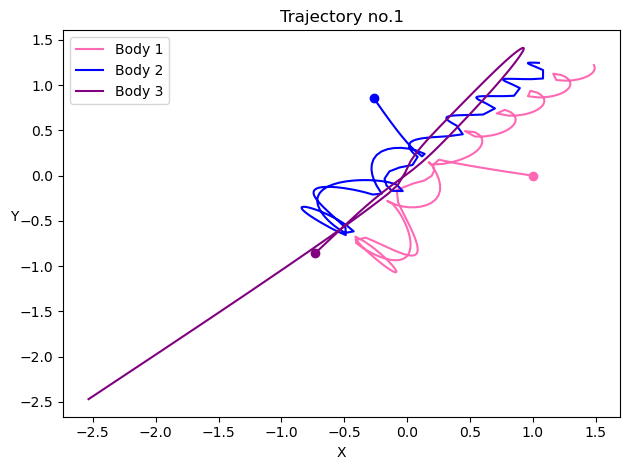

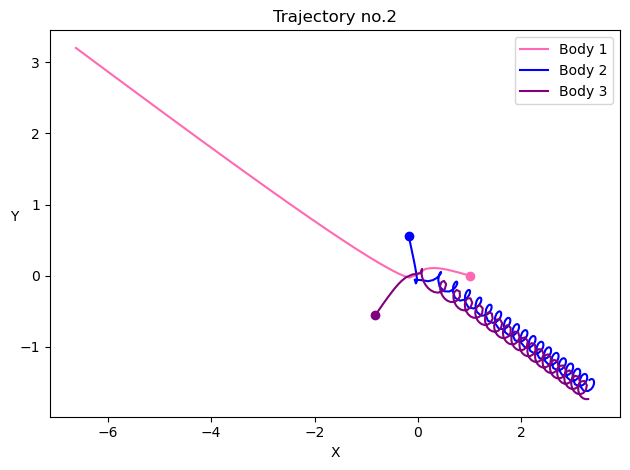

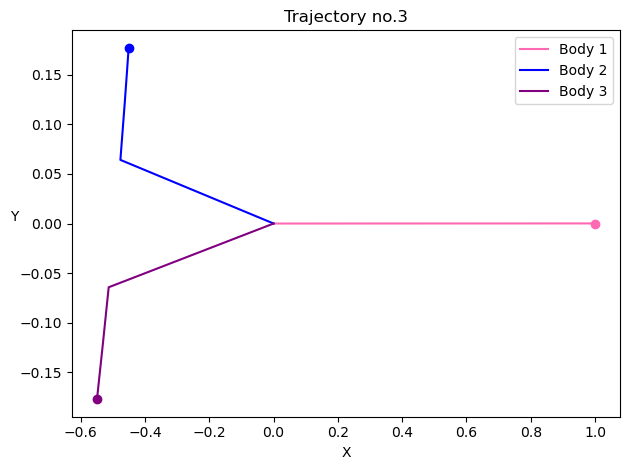

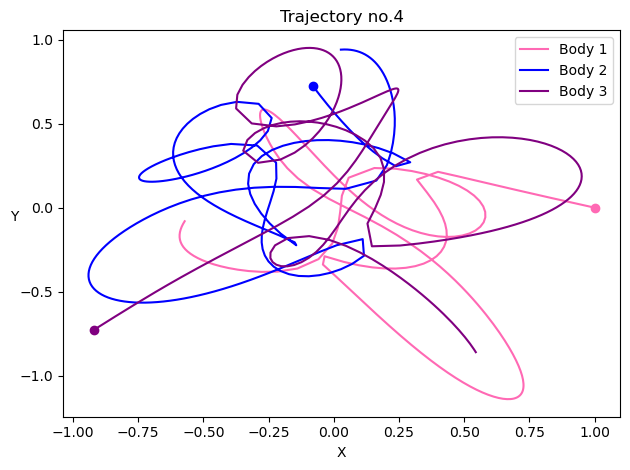

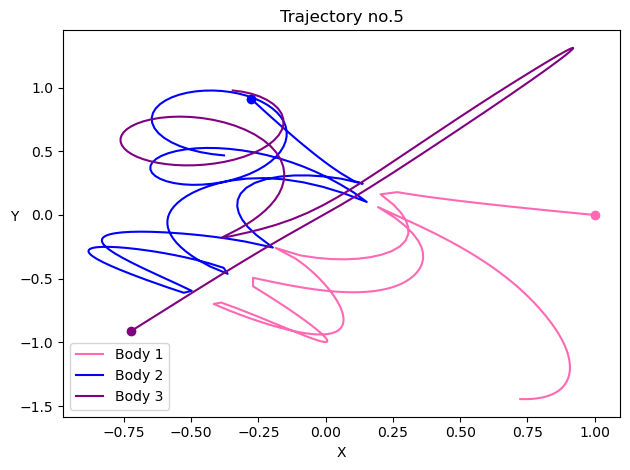

In [23]:
import matplotlib.pyplot as plt

start = 0
end = 257

for i in range(5):
    trajectory = df_train[start:end]
    x1, y1, x2, y2, x3, y3 = trajectory.x_1, trajectory.y_1, trajectory.x_2, trajectory.y_2, trajectory.x_3, trajectory.y_3
    plt.plot(x1, y1, color="hotpink", label = "Body 1")
    plt.plot(x2, y2, color="blue", label = "Body 2")
    plt.plot(x3, y3, color="purple", label = "Body 3")
    plt.scatter(x1[start], y1[start], color="hotpink")
    plt.scatter(x2[start], y2[start], color="blue")
    plt.scatter(x3[start], y3[start], color="purple")
    plt.xlabel("X")
    plt.ylabel("Y", rotation=0)
    plt.title("Trajectory no." + str(i+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    start += 257
    end += 257


# Prepare the dataset

In [24]:
df_train["group"] = df_train["Id"]//257

In [25]:
#All starting positions
df_init = df_train[ df_train.index%257 == 0]

In [26]:
df_combined = df_train.merge(df_init, on="group",  suffixes=('', '_init'))

In [27]:
X = df_combined[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
X.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
0,0.000000,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
1,0.039062,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
2,0.078125,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
3,0.117188,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
4,0.156250,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196


In [28]:
y = df_combined[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
y

,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022
...,...,...,...,...,...,...
12845,0.851272,-0.249634,-0.559102,-0.178468,-0.292171,0.428103
12846,0.848911,-0.236969,-0.576793,-0.170501,-0.272118,0.407470
12847,0.845009,-0.223814,-0.592066,-0.159406,-0.252944,0.383220
12848,0.839521,-0.210157,-0.604621,-0.145183,-0.234900,0.355339


In [29]:
groups = df_combined["group"]
groups

0         0
1         0
2         0
3         0
4         0
         ..
12845    49
12846    49
12847    49
12848    49
12849    49
Name: group, Length: 12850, dtype: int64

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
model_ridge = Ridge()
model_lasso = Lasso()

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model_ridge)
    ])
pipe

Pipeline(steps=[('scaling', StandardScaler()), ('model', Ridge())])

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

kfold = GroupKFold(n_splits=5)

rmse_list = [] 
y_hats = []
    
for fold_num, (train_index, test_index) in enumerate(kfold.split(X, y, groups=groups)):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    print("Fold")
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    y_hats.append(y_hat)
    rmse_list.append(mean_squared_error(y_test, y_hat, squared = False))

print(rmse_list)
print("AVG:", sum(rmse_list)/len(rmse_list))

Fold
Fold
Fold
Fold
Fold
[1.3325560912377445, 1.0879044417941341, 1.869450437372074, 0.9957731263552513, 1.4681886636607555]
AVG: 1.3507745520839918


In [33]:
import numpy as np

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

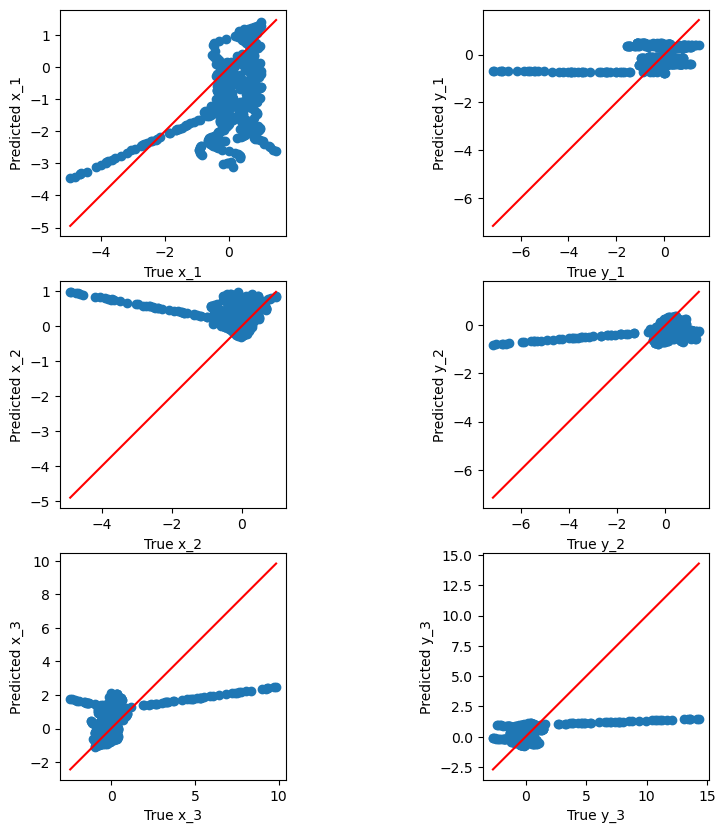

In [34]:
plot_y_yhat(y_test.to_numpy(), pd.DataFrame(y_hat).to_numpy())

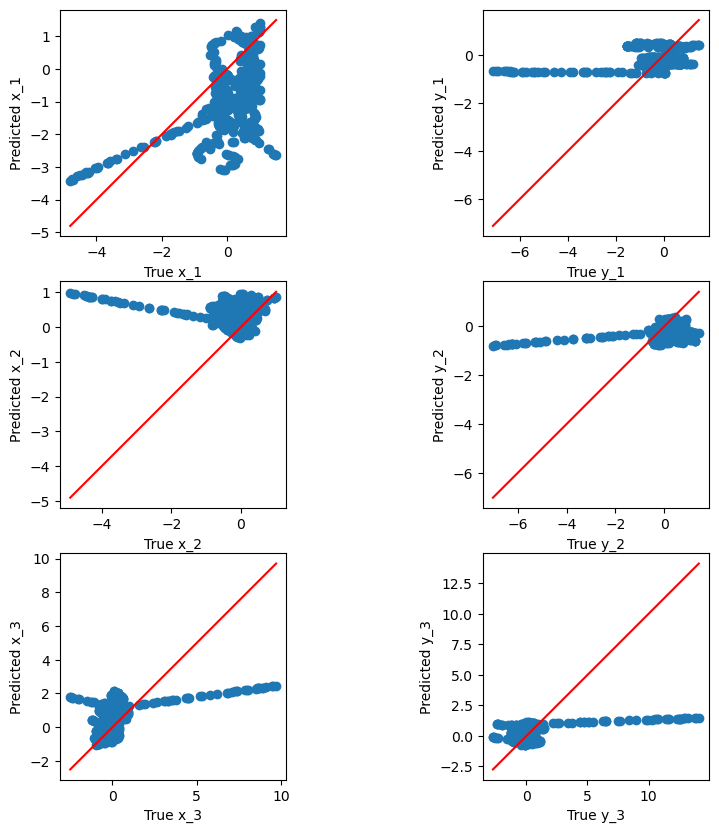

In [35]:
plot_y_yhat(y_test.to_numpy(), pd.DataFrame(y_hat).to_numpy())

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [38]:
pipe2= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=3)),
            ('model', Ridge())
    ])

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    
    best_rsme = 1000
    best_degree = 0
    train_scores = []
    test_scores = []
    n_features_list = []

    for d in degrees:

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)

        #print("Degree:", d) 

        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
        #print("Train MSE:", train_error)

        test_error = np.sqrt(mean_squared_error(y_val, y_val_predict))
        #print("Test MSE:", test_error)

        if test_error < best_rsme:
            best_rsme = test_error
            best_degree = d

        train_scores.append(train_error)
        test_scores.append(test_error)
    
    return train_scores, test_scores, best_rsme, best_degree, n_features_list

In [ ]:
from sklearn.model_selection import train_test_split

kfold = GroupKFold(n_splits=10)

degrees=range(1,15)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

X=X[0:12850]
y=y[0:12850]

X_subset, _, y_subset, _, groups_subset, _ = train_test_split(
    X, y, groups, test_size=0.25, stratify=groups)

for fold_num, (train_index, test_index) in enumerate(kfold.split(X_subset, y_subset, groups=groups_subset)):
    # Indexing with iloc
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Validate polynomial regression for each fold
    train_scores, test_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(X_train, y_train, X_test, y_test)
    
    best_rsmes.append(best_rsme)
    best_degrees.append(best_degree)

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(test_scores[d-1])


In [41]:
print("Best RSME: ", best_rsmes, 
        "\nBest degree: ", best_degrees, 
        "\nDegree scores: ", degree_scores, 
        "\nFeatures outputed" , n_features_list)

Best RSME:  [0.29099877987236417, 0.2927453487459015, 0.2794935482359774, 0.27442986521696594, 0.27845677420780474, 0.2746477138937524, 0.29357484726752675, 0.2656177240561981] 
Best degree:  [7, 7, 7, 7, 7, 7, 7, 7] 
Degree scores:  {1: {'train_scores': [1.2868157126400068, 1.2836109923840537, 1.2813648691089425, 1.2867235783722208, 1.2842655955634477, 1.3017575343240166, 1.2841237982630207, 1.2749193474207234], 'test_scores': [1.2905399357617124, 1.3191325021010276, 1.3388581198241893, 1.2926802851710553, 1.3134743612609128, 1.1475810692033517, 1.3151833664884396, 1.3928022030182747]}, 2: {'train_scores': [1.1847647866229403, 1.1810569669114894, 1.1805546867736854, 1.183888122081727, 1.1843908920426462, 1.1980245660789874, 1.1849061900572024, 1.1753953401523478], 'test_scores': [1.1963714653468958, 1.2301856807533327, 1.234061342831015, 1.2056977059020448, 1.2000871898043566, 1.070779607424387, 1.1962841517718776, 1.2772516189326653]}, 3: {'train_scores': [0.9787375089316099, 0.97852